# Changes:
1. Create a Pytorch Dataloader
2. Normalize input
3. Make the code runnable on Google Colab

In [4]:
!pip install torch torchvision

    100% |████████████████████████████████| 519.5MB 34kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x589ee000 @  0x7fcd075f71c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.1MB/s 
    100% |████████████████████████████████| 2.0MB 2.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [5]:
!pip install imageio

    100% |████████████████████████████████| 3.3MB 8.3MB/s 


In [6]:
! git clone https://github.com/allen-q/pytorch-learning.git

Cloning into 'pytorch-learning'...
remote: Counting objects: 741, done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 741 (delta 6), reused 15 (delta 5), pack-reused 721
Receiving objects: 100% (741/741), 281.71 MiB | 14.23 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [7]:
cd pytorch-learning/kaggle/salt/

/content/pytorch-learning/kaggle/salt/data


In [0]:
#!wget https://github.com/allen-q/pytorch-learning/raw/master/kaggle/salt/data/np_test_0.npy

In [0]:
#!wget https://github.com/allen-q/pytorch-learning/raw/master/kaggle/salt/data/np_test_1.npy

In [0]:
#!wget https://github.com/allen-q/pytorch-learning/raw/master/kaggle/salt/data/np_train_all.npy

In [0]:
#!wget https://github.com/allen-q/pytorch-learning/raw/master/kaggle/salt/data/np_train_all_mask.npy

In [0]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle

% matplotlib inline

In [0]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

In [0]:
def rle_encoder2d(x):
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy()
    s = pd.Series(x.clip(0,1).flatten('F'))
    s.index = s.index+1
    df = s.to_frame('pred').assign(zero_cumcnt=s.eq(0).cumsum())
    df = df.loc[df.pred.gt(0)]
    df_rle = df.reset_index().groupby('zero_cumcnt').agg({'index': min, 'pred': sum}).astype(int).astype(str)
    rle = ' '.join((df_rle['index'] + ' '+df_rle['pred']).tolist())
    
    return rle

In [0]:
def rle_encoder3d(x):   
    return np.r_[[rle_encoder2d(e) for e in x]]

In [0]:
def load_img_to_np(img_path, num_channel=1):
    images = []
    img_ids = []
    for filename in sorted(glob.glob(f'{img_path}/*.png')): #assuming png
        img_id = filename.split('\\')[-1].split('.')[0]
        img_ids.append(img_id)
        images.append(np.array(imageio.imread(filename), dtype=np.uint8).reshape(101,101,-1)[:,:,0:num_channel])
    return (np.r_[images], img_ids)

In [0]:
def load_single_img(path, show=False):
    img = np.array(imageio.imread(path), dtype=np.uint8)
    if show:
        plt.imshow(img, cmap='gray')
    return img

In [0]:
def format_train_data(X):
    X = np.moveaxis(X, -1,1)
    X = np.pad(X, [(0,0),(0,0),(0, 1), (0, 1)], mode='constant')
    return torch.from_numpy(X).float()

In [0]:
def get_train_batch(X_train, y_train, batch_size):
    batch_ids = np.random.choice(len(X_train), batch_size, replace=False)
    X_train_batch = X_train[batch_ids]
    X_train_batch = np.moveaxis(X_train_batch, -1,1)
    X_train_batch = np.pad(X_train_batch, [(0,0),(0,0),(0, 1), (0, 1)], mode='constant')
    y_train_batch = np.clip(y_train[batch_ids],0,1)
    
    return (torch.from_numpy(X_train_batch).float(), torch.from_numpy(y_train_batch).float())

In [0]:
def calc_raw_iou(a, b):
    if isinstance(a, torch.Tensor):
        a = a.detach().numpy()
    if isinstance(b, torch.Tensor):
        b = b.detach().numpy()
    a = np.clip(a, 0, 1)
    b = np.clip(b, 0, 1)
    u = np.sum(np.clip(a+b, 0, 1), (1,2)).astype(np.float)
    i = np.sum(np.where((a+b)==2, 1, 0), (1,2)).astype(np.float)
    with np.errstate(divide='ignore',invalid='ignore'):
        iou = np.where(i==u, 1, np.where(u==0, 0, i/u))
        
    return iou

In [0]:
def calc_mean_iou(a, b):
    thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
    iou = calc_raw_iou(a, b)
    iou_mean = (iou[:,None]>thresholds).mean(1).mean()

    return iou_mean

In [0]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def get_current_time_as_fname():
        timestamp = (
                dt.datetime.now(pytz.timezone('Australia/Melbourne'))
                .strftime('%Y_%m_%d_%H_%M_%S')
                )
                
        return timestamp

In [0]:
def plot_img_mask_pred(image, mask, pred=None):
    if pred is None:
        f, axarr = plt.subplots(1,2)
    else:
        f, axarr = plt.subplots(1,3)
    axarr[0].imshow(image, cmap='gray')
    axarr[1].imshow(mask, cmap='gray')    
    axarr[0].grid()
    axarr[1].grid()    
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')
    if pred is not None:
        axarr[2].imshow(pred, cmap='gray')
        axarr[2].grid()
        axarr[2].set_title('Predicted Mask')
    plt.show()

In [0]:
class SigToBinary(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, X):
        return X.ge(0.5)
    

In [0]:
class SaltNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1,64,3, padding=10),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,128,3),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,256,3),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 2, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        out = self.seq(X)
        return torch.clamp(out[:,:,:-1,:-1].squeeze(), 0.0, 1.0)

In [0]:
def adjust_predictions(black_img_mean, zero_mask_cut_off, mean_img, X, y_pred, y=None):
    y_pred_adj = y_pred.clip(0,1)

    # Set predictions to all 0 for black images
    black_img_mask = ((X+mean_img[None,:,:,None]).mean((1,2,3))<black_img_mean)
    y_pred_adj[black_img_mask]=0

    # set all predictions to 0 if the number of positive predictions is less than ZERO_MASK_CUTOFF
    y_pred_adj = np.r_[[e if e.sum()>zero_mask_cut_off else np.zeros_like(e) for e in y_pred_adj]]
    
    if y is not None:
        print(f'IOU score before: {calc_mean_iou(y_pred, y)}, IOU Score after:{calc_mean_iou(y_pred_adj, y)}')
        
    return y_pred_adj

In [0]:
def show_img_grid():
    pass
    #plt.imshow(torchvision.utils.make_grid(torch.from_numpy(y_train_black).unsqueeze(1)).permute(1, 2, 0))

## Constant and Parameter Defination

In [0]:
BLACK_IMG_MEAN = 50
ZERO_MASK_CUTOFF = 120

## Load Data

## Load train and test data from npy files or from raw images if npy files not exist.

In [33]:
try:
    print('Try loading data from npy and pickle files...')
    np_train_all = np.load('./data/np_train_all.npy')
    np_train_all_mask = np.load('./data/np_train_all_mask.npy')
    np_test = np.concatenate([np.load('./data/np_test_0.npy'), np.load('./data/np_test_1.npy')])
    with open('./data/misc_data.pickle', 'rb') as f:
        misc_data = pickle.load(f)
    print('Data loaded.')
except:
    print('npy files not found. Reload data from raw images...')
    np_train_all, np_train_all_ids = load_img_to_np('./data/train/images')
    np_train_all_mask, np_train_all_mask_ids = load_img_to_np('./data/train/masks')
    df_train_all_depth = pd.read_csv('./data/depths.csv').set_index('id')
    np_test, np_test_ids = load_img_to_np('./data/test/images')
    np.save('./data/np_train_all.npy', np_train_all)
    np.save('./data/np_train_all_mask.npy', np_train_all_mask)
    for k, v in enumerate(np.split(np_test,2)):
        np.save(f'./data/np_test_{k}.npy', v)
    misc_data = {'df_train_all_depth': df_train_all_depth,
                 'np_train_all_ids': np_train_all_ids,
                 'np_train_all_mask_ids': np_train_all_mask_ids,
                 'np_test_ids': np_test_ids}
    with open('./data/misc_data.pickle', 'wb') as f:
        pickle.dump(misc_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    print('Data loaded.')

Try loading data from npy and pickle files...
Data loaded.


## Train Val data split

In [0]:
X_train_ids, X_val_ids = (
    train_test_split(np.arange(len(np_train_all)), 
                     test_size=0.20, 
                     random_state=42)
)

In [0]:
X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]
depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
X_train_mean_img = X_train.mean(0).astype(np.float32)

In [0]:
class SaltDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, np_img, np_mask, df_depth, mean_img, transform=None):
        """
        Args:
            data_dir (string): Path to the image files.
            train (bool): Load train or test data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.np_img = np_img
        self.np_mask = np_mask
        self.df_depth = df_depth
        self.mean_img = mean_img
        self.transform = transform

    def __len__(self):
        return len(self.np_img)

    def __getitem__(self, idx):

        X = self.np_img[idx] - self.mean_img
        #print(X.dtype)
        X = np.moveaxis(X, -1,0)
        
        X = np.pad(X, [(0, 0),(0, 1), (0, 1)], mode='constant')
        #print(X.dtype)
        if self.np_mask is None:
            y = np.zeros(101,101,1)
        else:
            y = self.np_mask[idx].clip(0,1)
        d = self.df_depth.iloc[idx,0]
        #id = self.df_depth.index[idx]
        X = torch.from_numpy(X).float().type(dtype)
        y = torch.from_numpy(y).float().squeeze().type(dtype)

        if self.transform:
            X = self.transform(X)
        #from boxx import g
        #g()
        return (X,y,d,idx)

In [0]:
data_params = {'batch_size': 60,
               'shuffle': True,
               'drop_last': False}

In [79]:
X_val.shape

(800, 101, 101, 1)

In [0]:
train_dataLoader = DataLoader(SaltDataset(X_train, y_train, depth_train, X_train_mean_img), **data_params)

In [0]:
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img), **data_params)

In [0]:
test_dataLoader = DataLoader(SaltDataset(np_test, None, depth_test, X_train_mean_img), **data_params)

In [0]:
t = iter(train_dataLoader).__next__()

In [46]:
t[3].is_cuda

False

In [0]:
class IOU_Loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, y_pred, y):
        #print(y_pred.requires_grad)
        #y_pred = torch.where(y_pred.ge(0.5), torch.tensor(1.0), torch.tensor(0.0))
        i = y_pred.mul(y)
        u = (y_pred + y) - i
        mean_iou = torch.mean(i.view(i.shape[0],-1).sum(1) / u.view(i.shape[0],-1).sum(1))
        iou_loss = 1 - mean_iou
        #from boxx import g
        #g()
        
        return iou_loss

## Create a Model

In [0]:
saltnet = SaltNet()

In [0]:
loss_fn = nn.BCELoss()
#loss_fn = IOU_Loss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)

In [0]:
start = time.time()

In [0]:
TRAIN_MODE = True

In [52]:
list(saltnet.parameters())[0].sum()

tensor(5.9656, grad_fn=<SumBackward0>)

In [0]:
list(saltnet.parameters())[-1].grad

In [0]:
#X_batch, y_batch = get_train_batch(X_train, y_train, batch_size=2)

In [0]:
max_epochs = 50
iter_count = 0
all_losses = []

In [68]:
saltnet.cuda()

SaltNet(
  (seq): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(10, 10))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ConvTranspose

Loss is 0.3744865357875824, IOU is 0.25833333333333336 at iter 0, Time: 5m 7s


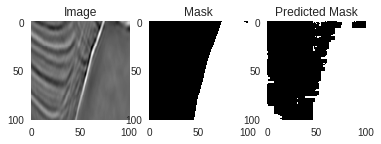

Loss is 0.3488996967673302, IOU is 0.35500000000000004 at iter 50, Time: 5m 15s


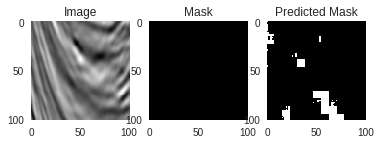

Loss is 0.31167917549610136, IOU is 0.4233333333333334 at iter 100, Time: 5m 23s


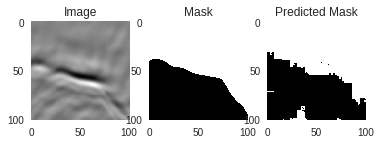

Loss is 0.31012241169810295, IOU is 0.28833333333333333 at iter 150, Time: 5m 32s


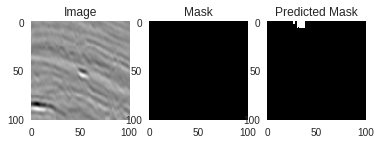

Loss is 0.29391201213002205, IOU is 0.48000000000000004 at iter 200, Time: 5m 40s


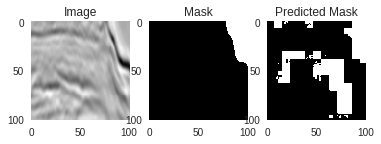

Loss is 0.27826144769787786, IOU is 0.385 at iter 250, Time: 5m 49s


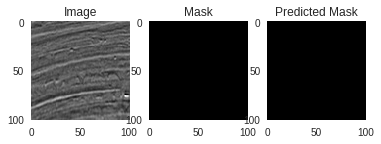

Loss is 0.3031697355210781, IOU is 0.40166666666666667 at iter 300, Time: 5m 57s


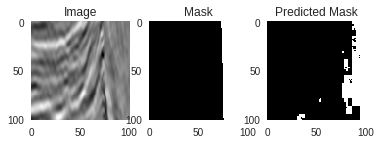

Loss is 0.27801238298416137, IOU is 0.33666666666666667 at iter 350, Time: 6m 5s


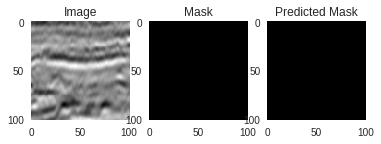

Loss is 0.26268984377384186, IOU is 0.38 at iter 400, Time: 6m 14s


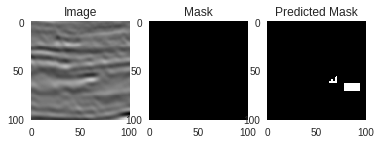

Loss is 0.2591149091720581, IOU is 0.34833333333333333 at iter 450, Time: 6m 22s


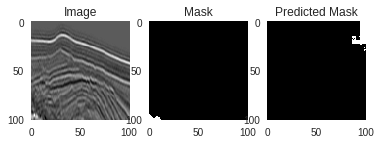

Loss is 0.27343006879091264, IOU is 0.44333333333333325 at iter 500, Time: 6m 31s


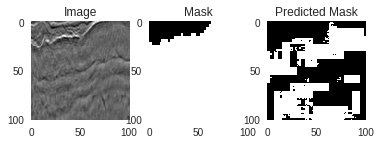

Loss is 0.2544048622250557, IOU is 0.3516666666666666 at iter 550, Time: 6m 39s


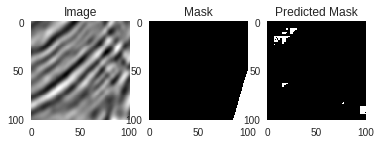

Loss is 0.23543158173561096, IOU is 0.44166666666666665 at iter 600, Time: 6m 47s


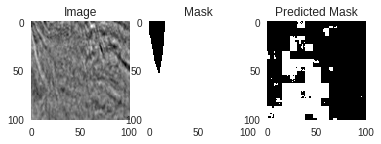

Loss is 0.2425665847957134, IOU is 0.6066666666666667 at iter 650, Time: 6m 56s


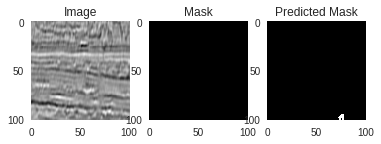

Loss is 0.25354511961340903, IOU is 0.3416666666666667 at iter 700, Time: 7m 4s


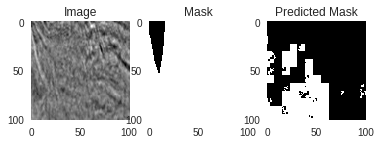

Loss is 0.23759449794888496, IOU is 0.38999999999999996 at iter 750, Time: 7m 13s


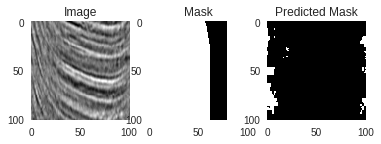

Loss is 0.2332192175090313, IOU is 0.46 at iter 800, Time: 7m 21s


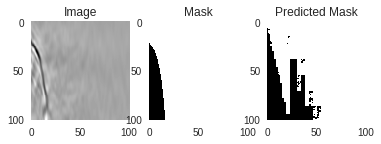

Loss is 0.233338825404644, IOU is 0.4133333333333333 at iter 850, Time: 7m 29s


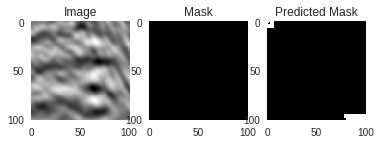

Loss is 0.21634851023554802, IOU is 0.4716666666666667 at iter 900, Time: 7m 38s


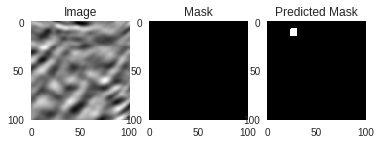

Loss is 0.21802039369940757, IOU is 0.505 at iter 950, Time: 7m 46s


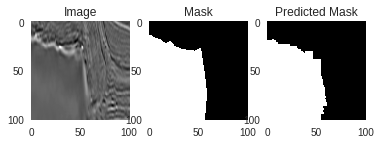

Loss is 0.22797363474965096, IOU is 0.4516666666666666 at iter 1000, Time: 7m 55s


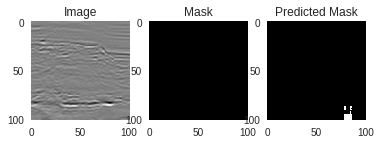

Loss is 0.21396393850445747, IOU is 0.3866666666666667 at iter 1050, Time: 8m 3s


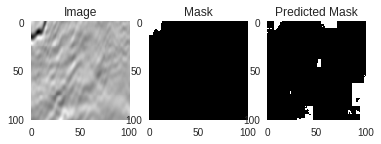

Loss is 0.2184958927333355, IOU is 0.47 at iter 1100, Time: 8m 11s


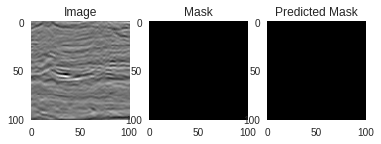

Loss is 0.23739348351955414, IOU is 0.45666666666666667 at iter 1150, Time: 8m 20s


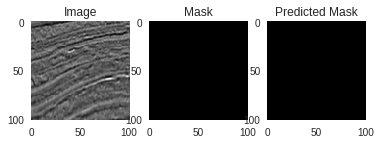

Loss is 0.21502933725714685, IOU is 0.38333333333333336 at iter 1200, Time: 8m 28s


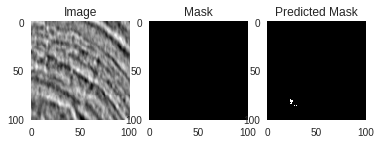

Loss is 0.2250147819519043, IOU is 0.5433333333333333 at iter 1250, Time: 8m 37s


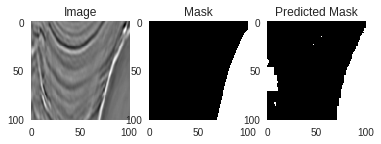

Loss is 0.213105259090662, IOU is 0.5316666666666666 at iter 1300, Time: 8m 45s


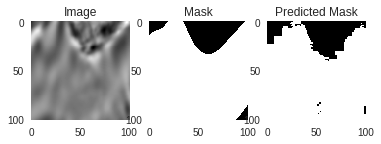

Loss is 0.22363896071910858, IOU is 0.44666666666666666 at iter 1350, Time: 8m 53s


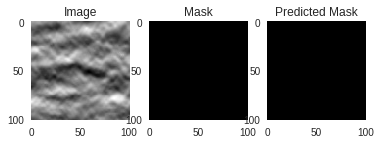

Loss is 0.2231704331934452, IOU is 0.43833333333333335 at iter 1400, Time: 9m 2s


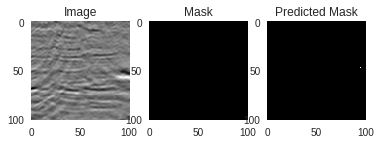

Loss is 0.20905127823352815, IOU is 0.5616666666666668 at iter 1450, Time: 9m 10s


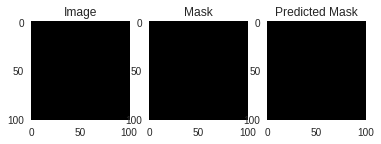

Loss is 0.19691274240612983, IOU is 0.46666666666666673 at iter 1500, Time: 9m 19s


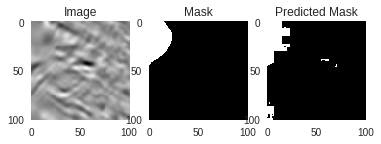

Loss is 0.20216095969080924, IOU is 0.57 at iter 1550, Time: 9m 27s


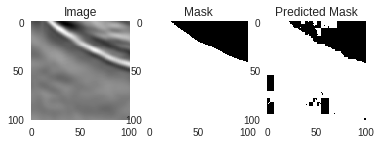

Loss is 0.2015194684267044, IOU is 0.41000000000000003 at iter 1600, Time: 9m 36s


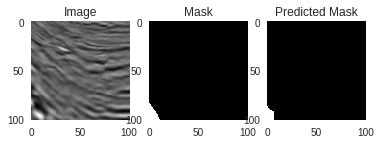

Loss is 0.17832216769456863, IOU is 0.5233333333333333 at iter 1650, Time: 9m 44s


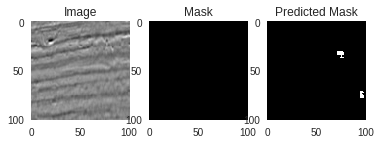

Loss is 0.18727891519665718, IOU is 0.5349999999999999 at iter 1700, Time: 9m 52s


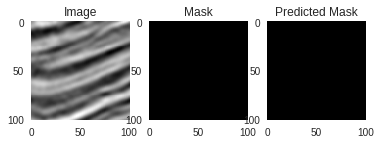

Loss is 0.18170492351055145, IOU is 0.44 at iter 1750, Time: 10m 1s


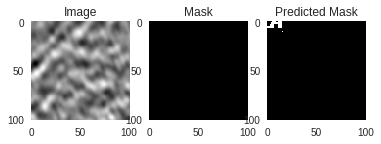

Loss is 0.20083439610898496, IOU is 0.5999999999999999 at iter 1800, Time: 10m 9s


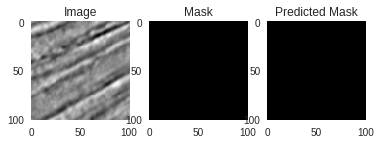

Loss is 0.1841705646365881, IOU is 0.51 at iter 1850, Time: 10m 17s


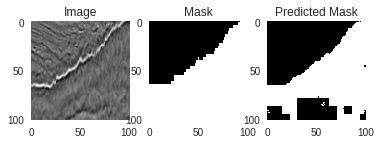

Loss is 0.1922760434448719, IOU is 0.41500000000000004 at iter 1900, Time: 10m 26s


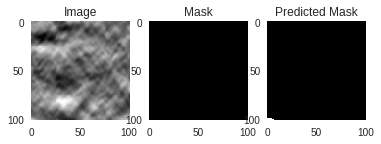

Loss is 0.20979161076247693, IOU is 0.4966666666666667 at iter 1950, Time: 10m 34s


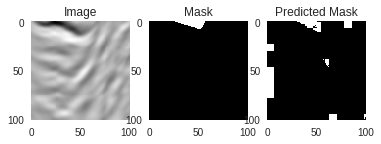

Loss is 0.1982345275580883, IOU is 0.38166666666666665 at iter 2000, Time: 10m 43s


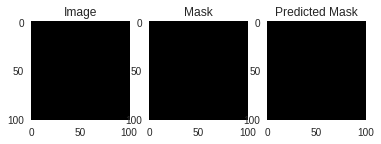

Loss is 0.20323336273431777, IOU is 0.415 at iter 2050, Time: 10m 51s


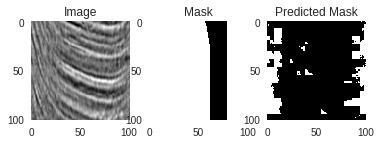

Loss is 0.17546448484063148, IOU is 0.52 at iter 2100, Time: 11m 0s


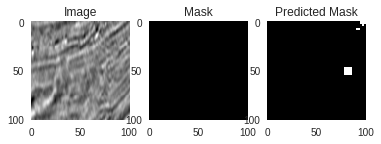

Loss is 0.18497256860136985, IOU is 0.48333333333333334 at iter 2150, Time: 11m 8s


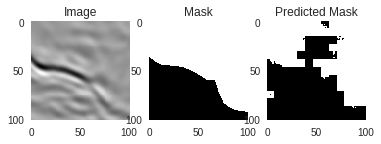

Loss is 0.1966288335621357, IOU is 0.39166666666666666 at iter 2200, Time: 11m 16s


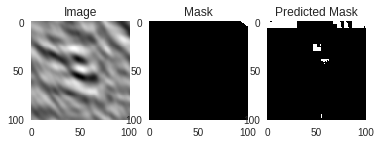

Loss is 0.17053004130721092, IOU is 0.43166666666666664 at iter 2250, Time: 11m 25s


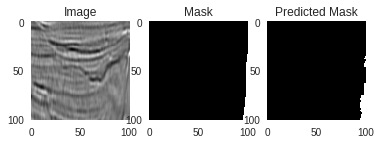

Loss is 0.18332741186022758, IOU is 0.3983333333333333 at iter 2300, Time: 11m 33s


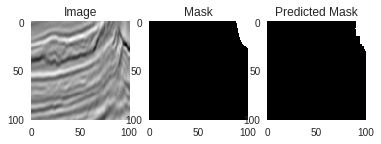

Loss is 0.19560987688601017, IOU is 0.4733333333333334 at iter 2350, Time: 11m 42s


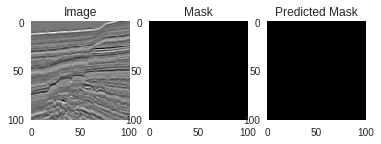

Loss is 0.17254328429698945, IOU is 0.5216666666666667 at iter 2400, Time: 11m 50s


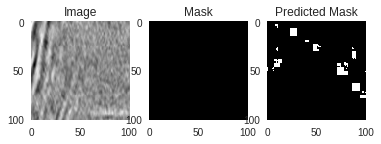

Loss is 0.18114113211631774, IOU is 0.515 at iter 2450, Time: 11m 58s


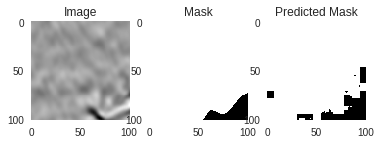

Loss is 0.17455937154591084, IOU is 0.49000000000000005 at iter 2500, Time: 12m 7s


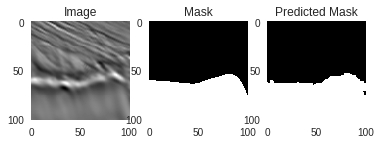

Loss is 0.1803466148674488, IOU is 0.5249999999999999 at iter 2550, Time: 12m 15s


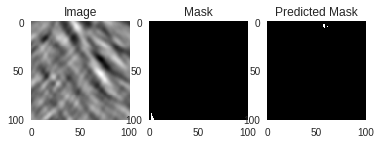

Loss is 0.17777351327240468, IOU is 0.3266666666666666 at iter 2600, Time: 12m 24s


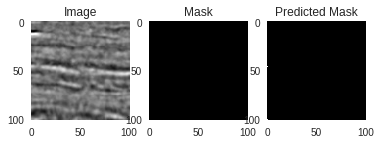

Loss is 0.16296992115676404, IOU is 0.5216666666666667 at iter 2650, Time: 12m 32s


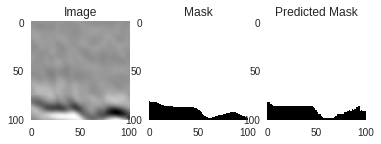

In [69]:
if TRAIN_MODE:
    for epoch in range(max_epochs):
        
        for X_batch, y_batch, d_batch, X_id in train_dataLoader:
            #y_pred = torch.tensor(saltnet(X_batch).ge(0.5).float(), requires_grad=True)

            y_pred = saltnet(X_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch.float())
            loss.backward()
            optimizer.step()
            all_losses.append(loss.item())

            #from boxx import g
            #g()
            if iter_count % 50 == 0:
                iou_batch = calc_mean_iou(y_pred.ge(0.5).cpu(), y_batch.float().cpu())
                print(f'Loss is {np.mean(all_losses[-20:])}, IOU is {iou_batch} at iter {iter_count}, Time: {timeSince(start)}')
                plot_img_mask_pred(X_train[X_id[0]].squeeze(), y_train[X_id[0]].squeeze(), y_pred[0].squeeze().gt(0.5))

            iter_count+=1

In [70]:
b

NameError: ignored

In [0]:
y_pred_np = y_pred.ge(0.5).cpu().detach().numpy()

In [0]:
y_batch_np = y_batch.cpu().detach().numpy()

In [74]:
calc_raw_iou(y_pred_np, y_batch_np)

array([0.67088608, 1.        , 1.        , 1.        , 1.        ,
       0.44526705, 0.9822695 , 0.        , 0.76169462, 0.78042498,
       0.61021136, 0.96136418, 0.94235001, 0.98726557, 0.        ,
       0.907743  , 1.        , 1.        , 0.        , 0.        ])

In [75]:
calc_mean_iou(y_pred_np, y_batch_np)

0.635

In [0]:
if TRAIN_MODE:
    state = {'epoch': i + 1, 'state_dict': saltnet.state_dict(),
                 'optimizer': optimizer.state_dict() }
    ckp_name = f'saltnet_{get_current_time_as_fname()}.ckp'
    torch.save(state, ckp_name)

## Load checkpoint

In [0]:
state = torch.load('saltnet_v1_20180808_0837.cpt')

In [0]:
saltnet.load_state_dict(state['state_dict'])

### Set model to evaluation mode

In [77]:
saltnet.eval()

SaltNet(
  (seq): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(10, 10))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ConvTranspose

In [0]:
assert saltnet.training == False

### Make Predictions on validation set

In [0]:
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img), batch_size=800)

In [0]:
with torch.no_grad():
    for x,y,d,id in val_dataLoader:
        y_val_pred = saltnet(x)



In [0]:
y_val_pred = y_val_pred.ge(0.5).cpu().detach().numpy()

796


TypeError: ignored

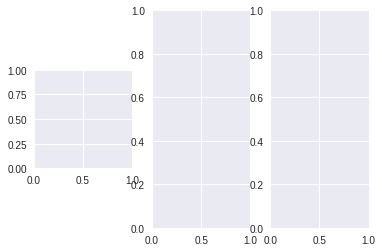

In [85]:
for i in range(10):
    rand_id = np.random.choice(len(X_val))
    print(rand_id)
    val_img = X_val[rand_id] + X_train_mean_img[:,:,None]
    val_mask = y_val[rand_id]
    val_mask_pred = y_val_pred[rand_id]
    plot_img_mask_pred(val_img, val_mask, val_mask_pred)

In [0]:
X_train_mean_img

In [107]:
y_val.shape

(800, 101, 101, 1)

In [108]:
y_val_pred = adjust_predictions(BLACK_IMG_MEAN, ZERO_MASK_CUTOFF, X_train_mean_img.squeeze(), X_val, y_val_pred, y_val.squeeze())

IOU score before: 0.44487499999999996, IOU Score after:0.62225


In [0]:
df_train['striped'] = df_train.apply(lambda x: np.any(x['mask']) & np.all(np.mod(x['mask'].sum(0),101)==0), axis=1)

In [0]:
df_train.striped.value_counts()

False    3887
True      113
Name: striped, dtype: int64

In [0]:
df_train.loc[df_train.striped].index

Index(['00950d1627', '0280deb8ae', '06d21d76c4', '09152018c4', '09b9330300',
       '0b45bde756', '130229ec15', '15d76f1672', '182bfc6862', '1eaf42beee',
       ...
       'e73ed6e7f2', 'f0c401b64b', 'f19b7d20bb', 'f641699848', 'f6e87c1458',
       'f7380099f6', 'f75842e215', 'fb3392fee0', 'fb47e8e74e', 'febd1d2a67'],
      dtype='object', name='img_id', length=113)

In [0]:
df_depth = pd.read_csv('./data/depths.csv').set_index('id')

In [0]:
df_depth.loc['00950d1627'].z

922

File name:00950d1627, depth:922


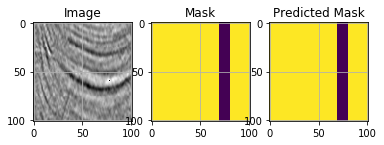

File name:0280deb8ae, depth:363


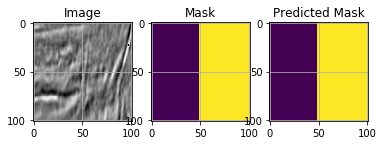

File name:06d21d76c4, depth:82


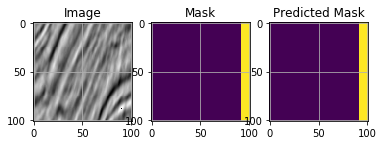

File name:09152018c4, depth:916


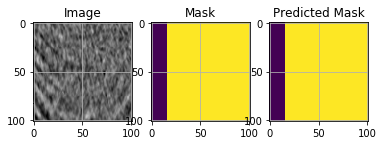

File name:09b9330300, depth:842


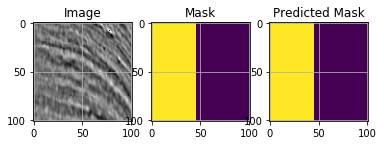

File name:0b45bde756, depth:92


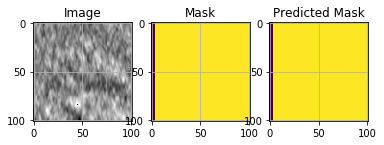

File name:130229ec15, depth:530


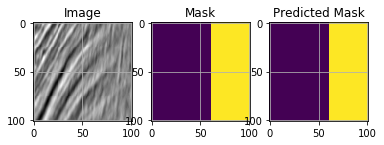

File name:15d76f1672, depth:494


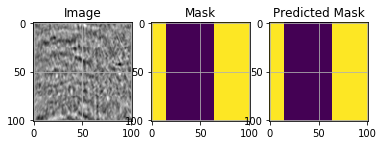

File name:182bfc6862, depth:363


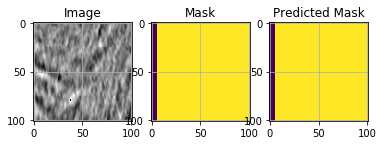

File name:1eaf42beee, depth:802


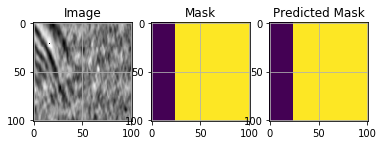

File name:23afbccfb5, depth:338


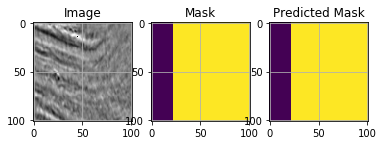

File name:24522ec665, depth:298


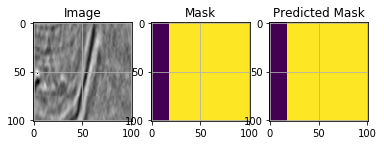

File name:285f4b2e82, depth:824


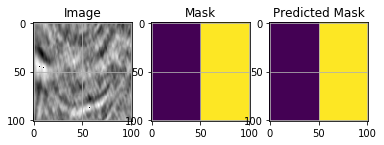

File name:2bc179b78c, depth:318


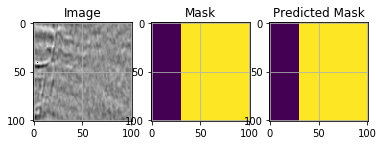

File name:2f746f8726, depth:297


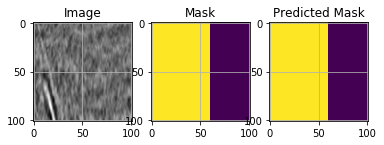

File name:33887a0ae7, depth:723


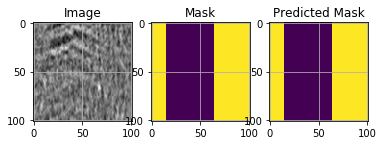

File name:33dfce3a76, depth:780


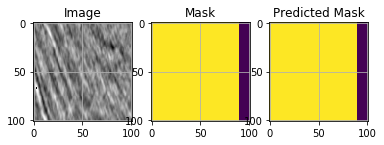

File name:3975043a11, depth:730


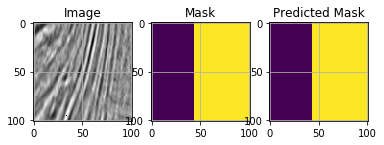

File name:39cd06da7d, depth:531


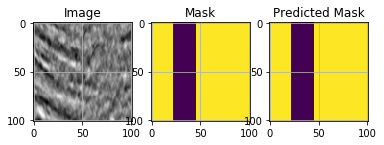

File name:3cb59a4fdc, depth:603


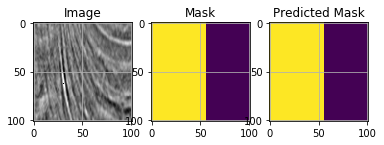

File name:403cb8f4b3, depth:661


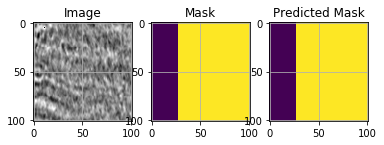

File name:483b35d589, depth:691


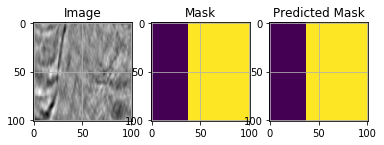

File name:49336bb17b, depth:385


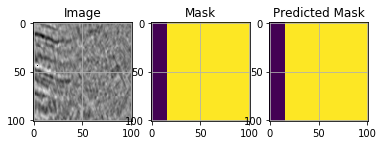

File name:4ef0559016, depth:700


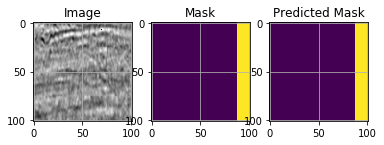

File name:4f5df40ab2, depth:514


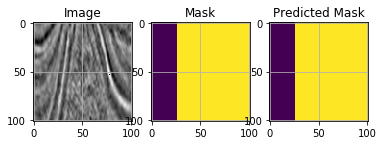

File name:4fbda008c7, depth:332


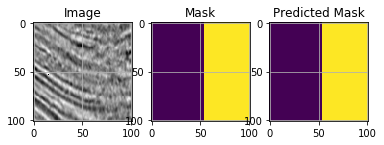

File name:4fdc882e4b, depth:955


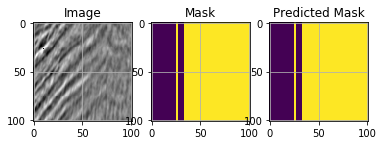

File name:50b3aef4c4, depth:116


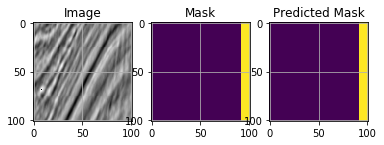

File name:50d3073821, depth:810


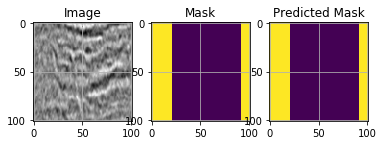

File name:52667992f8, depth:378


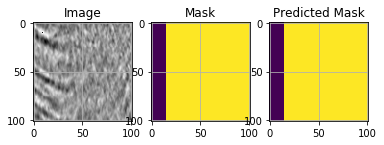

File name:52ac7bb4c1, depth:400


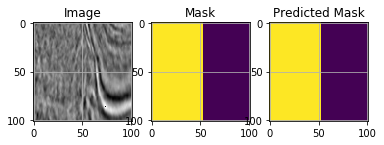

File name:53e17edd83, depth:738


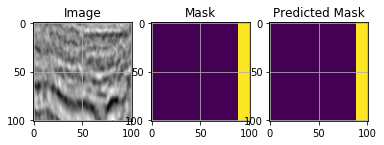

File name:56f4bcc716, depth:662


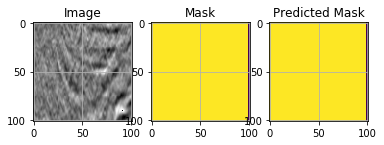

File name:58de316918, depth:901


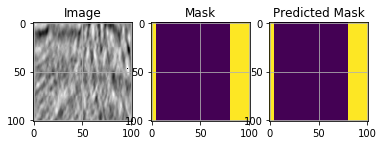

File name:5b217529e7, depth:446


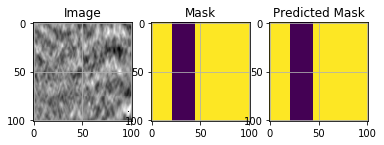

File name:5f98029612, depth:193


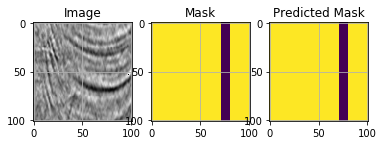

File name:608567ed23, depth:325


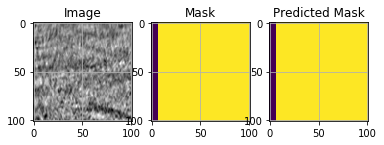

File name:62aad7556c, depth:926


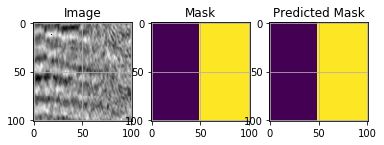

File name:62d30854d7, depth:427


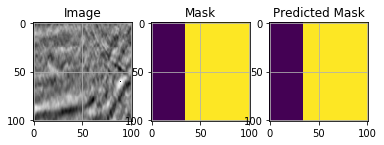

File name:640ceb328a, depth:612


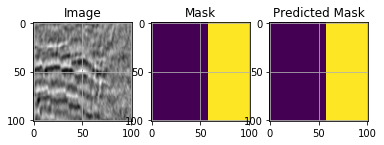

File name:6460ce2df7, depth:746


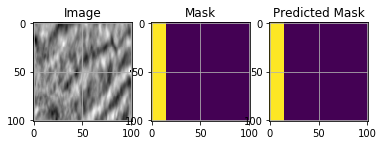

File name:6bc4c91c27, depth:655


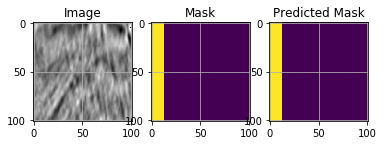

File name:71f7425387, depth:944


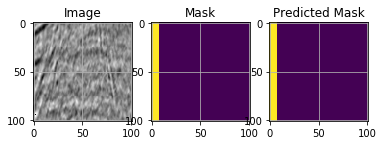

File name:7845115d01, depth:343


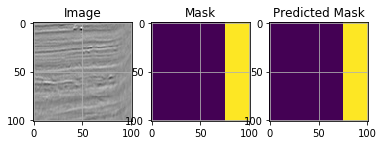

File name:7c0b76979f, depth:117


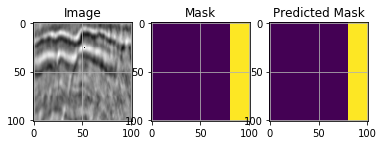

File name:7deaf30c4a, depth:365


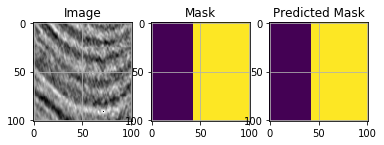

File name:7f0825a2f0, depth:136


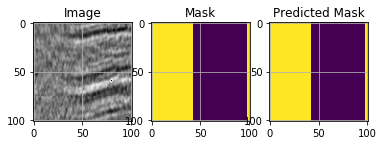

File name:80a458a2b6, depth:94


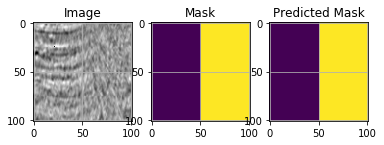

File name:81fa3d59b8, depth:857


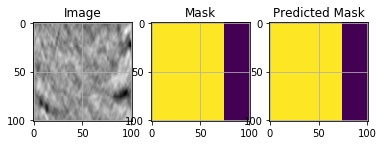

File name:834861f1b6, depth:461


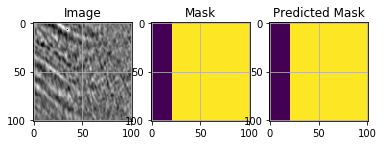

File name:8367b54eac, depth:615


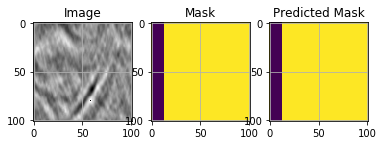

File name:849881c690, depth:701


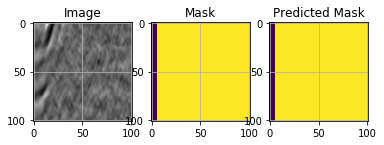

File name:876e6423e6, depth:882


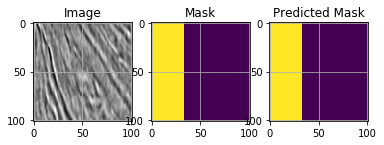

File name:87afd4b1ca, depth:668


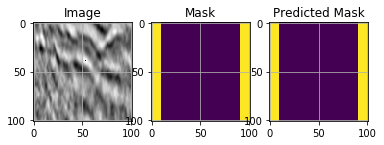

File name:88a5c49514, depth:948


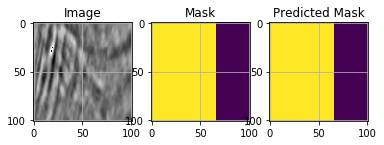

File name:9067effd34, depth:870


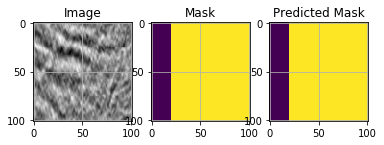

File name:90720e8172, depth:742


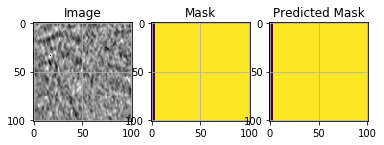

File name:916aff36ae, depth:946


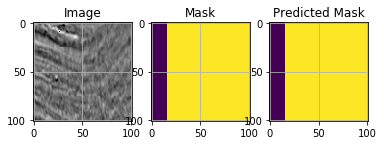

File name:919bc0e2ba, depth:352


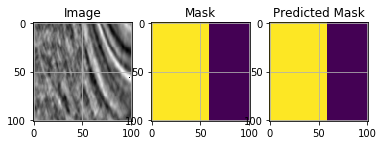

File name:93a1541218, depth:294


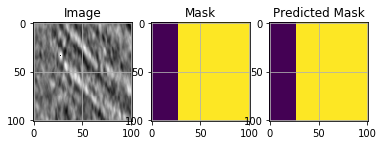

File name:95f6e2b2d1, depth:141


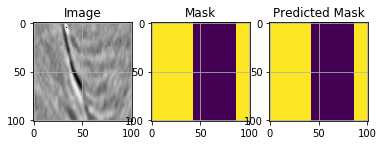

File name:96216dae3b, depth:166


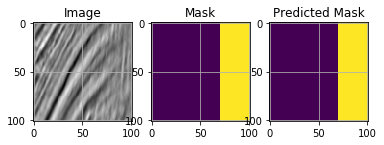

File name:96523f824a, depth:752


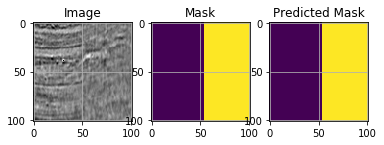

File name:99ee31b5bc, depth:241


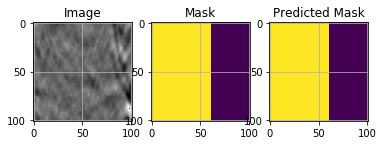

File name:9a4b15919d, depth:259


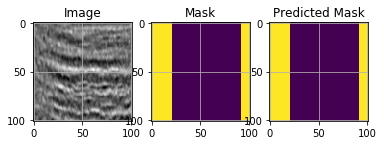

File name:9b29ca561d, depth:349


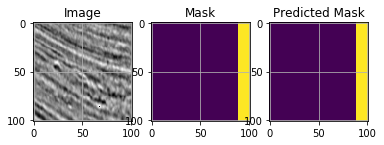

File name:9eb4a10b98, depth:581


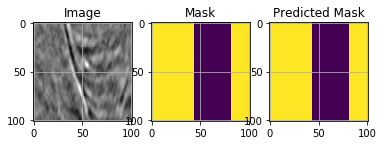

File name:a266a2a9df, depth:794


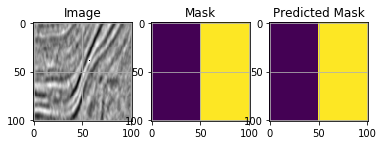

File name:a6625b8937, depth:944


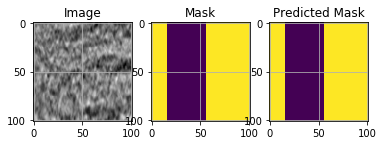

File name:a9ee40cf0d, depth:438


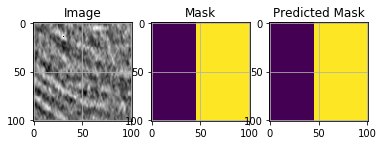

File name:ad2fa649f7, depth:858


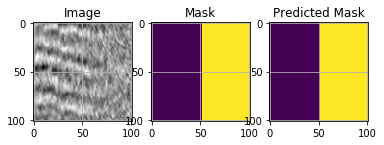

File name:aeba5383e4, depth:352


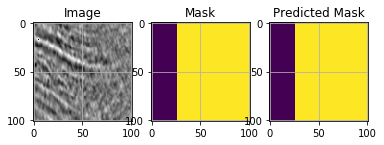

File name:b1be1fa682, depth:95


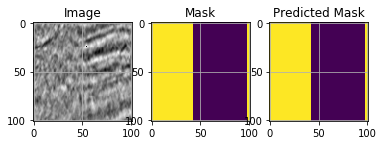

File name:b24d3673e1, depth:945


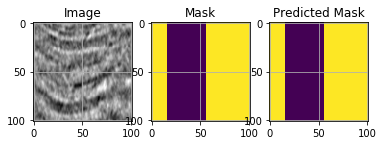

File name:b35b1b412b, depth:737


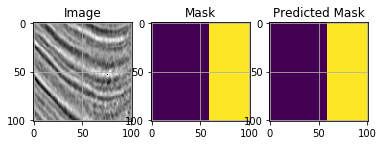

File name:b525824dfc, depth:628


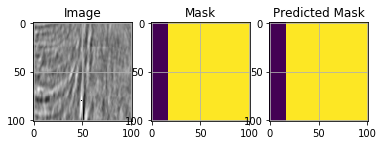

File name:b63b23fdc9, depth:194


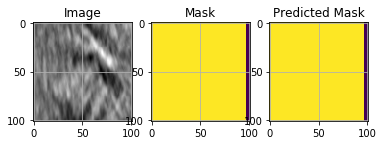

File name:b7b83447c4, depth:87


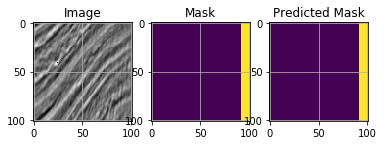

File name:b8a9602e21, depth:527


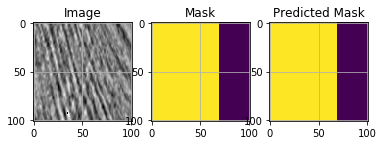

File name:ba1287cb48, depth:566


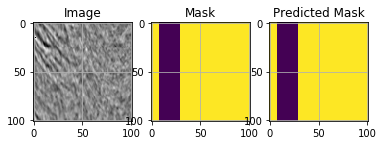

File name:baac3469ae, depth:491


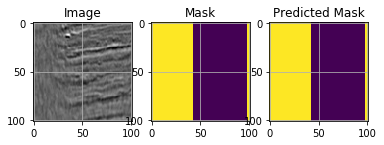

File name:be18a24c49, depth:314


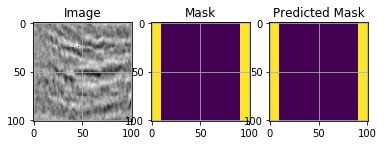

File name:be7014887d, depth:715


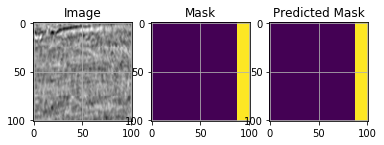

File name:be90ab3e56, depth:407


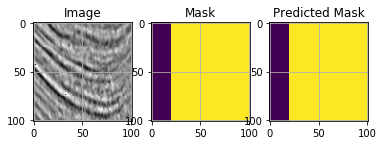

File name:bfa7ee102e, depth:844


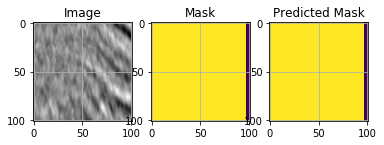

File name:bfbb9b9149, depth:802


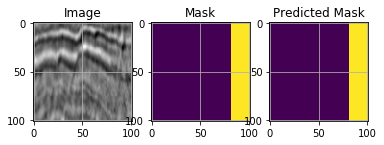

File name:c27409a765, depth:766


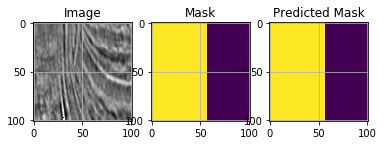

File name:c2973c16f1, depth:869


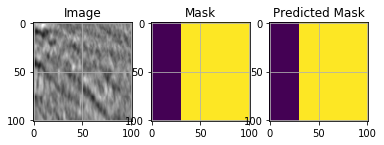

File name:c387a012fc, depth:478


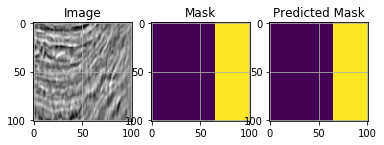

File name:c83d9529bd, depth:822


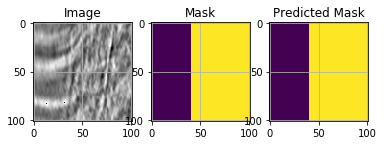

File name:c98dfd50ba, depth:558


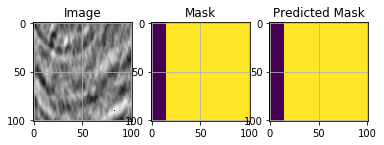

File name:caccd6708f, depth:747


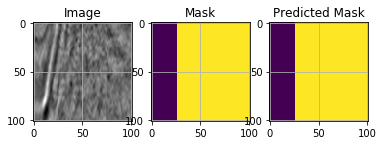

File name:cb4f7abe67, depth:183


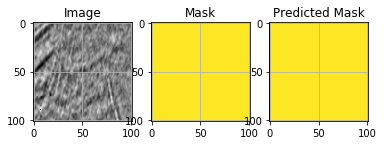

File name:cef03959d8, depth:221


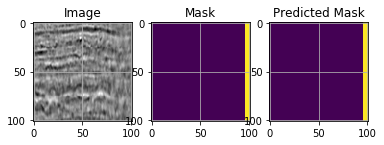

File name:d0bbe4fd97, depth:847


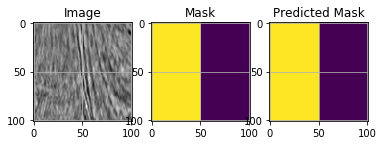

File name:d4d2ed6bd2, depth:330


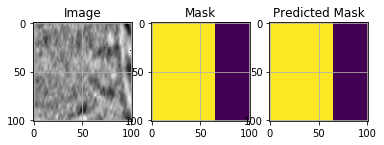

File name:d4d34af4f7, depth:114


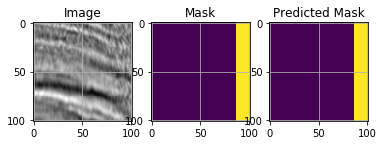

File name:d9a52dc263, depth:609


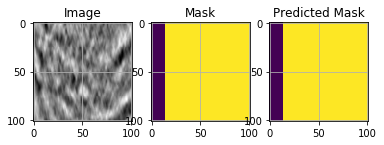

File name:dd6a04d456, depth:446


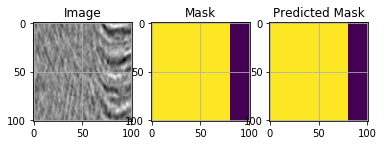

File name:ddcb457a07, depth:681


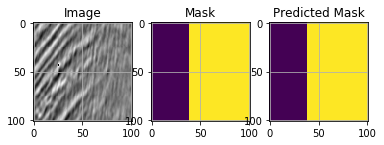

File name:de7202d286, depth:518


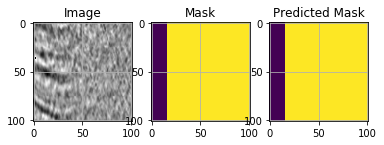

File name:e12cd094a6, depth:758


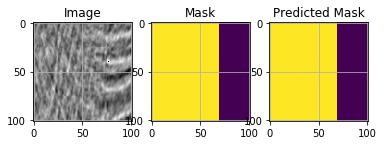

File name:e6e3e58c43, depth:448


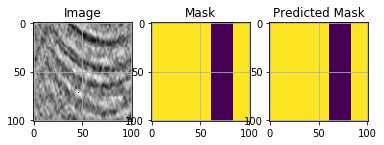

File name:e73ed6e7f2, depth:887


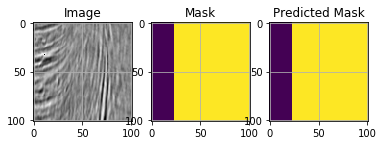

File name:f0c401b64b, depth:625


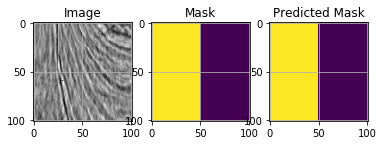

File name:f19b7d20bb, depth:451


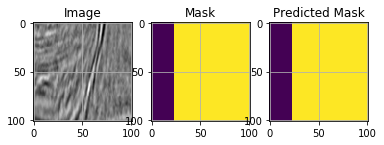

File name:f641699848, depth:552


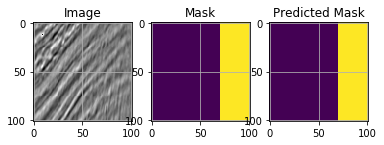

File name:f6e87c1458, depth:128


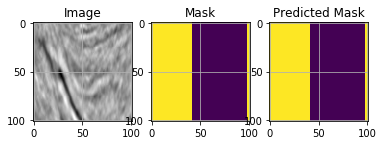

File name:f7380099f6, depth:796


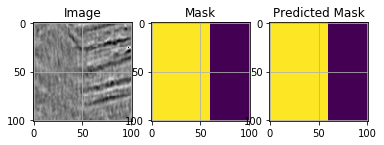

File name:f75842e215, depth:453


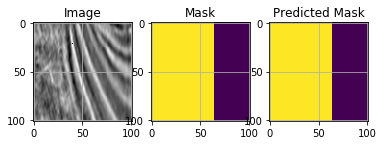

File name:fb3392fee0, depth:261


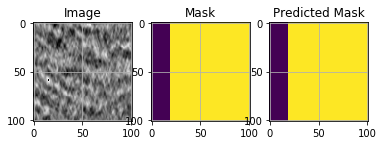

File name:fb47e8e74e, depth:757


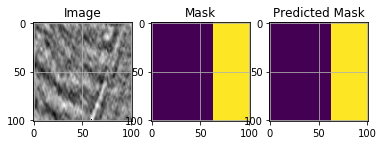

File name:febd1d2a67, depth:211


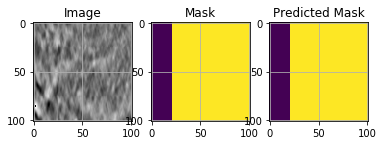

In [0]:
for i in df_train.loc[df_train.striped].index:
    #rand_id = np.random.choice(len(X_val))
    print(f'File name:{i}, depth:{df_depth.loc[i].z}')    
    img = df_train.img[i] + mean_img[:,:,None]
    mask = df_train['mask'][i]
    mask_pred = mask
    plot_img_mask_pred(img, mask, mask_pred)

## Make predictions on test set

In [0]:
y_test_pred_raw = []

In [0]:
for x in np.split(X_test, 36):
    with torch.no_grad():
        y_test_pred_raw.append(saltnet(format_train_data(x)))

In [0]:
y_test_pred_raw = torch.cat(y_test_pred_raw)

In [0]:
y_test_pred = y_test_pred_raw.ge(0.5).detach().numpy()

### Show segmentation masks for a few images

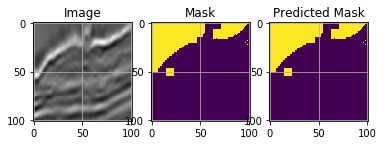

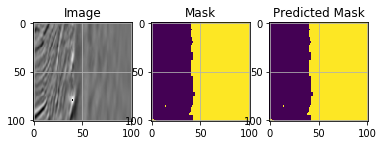

In [0]:
for i in range(2):
    rand_id = np.random.choice(len(X_test))
    #print(rand_id)
    img = X_test[rand_id] + mean_img[:,:,None]
    #mask = y_train[rand_id]
    mask_pred = y_test_pred[rand_id]
    plot_img_mask_pred(img, mask_pred, mask_pred)

### Adjust predictions

In [0]:
y_test_pred = adjust_predictions(BLACK_IMG_MEAN, ZERO_MASK_CUTOFF, mean_img, X_test, y_test_pred)

### Encode predictions using RLE(Run Length Encoding) method

In [0]:
y_test_pred_rle = rle_encoder3d(y_test_pred)

In [0]:
df_test_rle = pd.DataFrame(index=df_test.index, data=y_test_pred_rle).reset_index()

In [0]:
df_test_rle.columns = ['id', 'rle_mask']

In [0]:
df_test_rle[df_test_rle.rle_mask==''].shape

(6665, 2)

In [0]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)